<div style="display: flex; justify-content: space-between; align-items: flex-start;">
    <div style="flex: 0 0 auto; margin-bottom: 0; margin-top: 10px;">
        <img src="SAGE_logo.jpeg" alt="NSF SAGE Logo" width="150"/>
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0;">
        <img src="https://www.sci.utah.edu/images/news/2023/sci-30-multi.jpg" alt="Scientific Computing and Imaging Institute Logo" width="100"/>
    </div>
</div>

<h1 style="text-align: center; margin-top: 0;">NSF National Data Platform (NDP)</h1>

<h3 style="text-align: center; margin-top: 0;">Streaming Data from SAGE Pilot</h3>

This use case serves as a practical demonstration of NDP's streaming capabilities, specifically in its integration with the NSF SAGE platform. It primarily focuses on real-time data collection from sensors located at SAGE [node W023](https://portal.sagecontinuum.org/node/W023). This data is then streamed through a broker system. Subsequently, the system compiles this streamed data into historical data files. These files are not only preserved in an archive but are also made easily discoverable and accessible through the comprehensive services offered by NDP. This setup exemplifies the seamless fusion of real-time data acquisition and long-term data storage, enhancing both the immediacy and the utility of the information gathered from the sensors.

![SAGE NDP diagram](schema.png)

The figure above outlines a data processing workflow of the use case, utilizing an architecture that connects several components. 

1. **SAGE**: Represents a software-defined sensor network designed for AI at the edge. Data is retried through its API.
2. **API-baed Stream Adapter**: This component acts as an adapter that connects the SAGE platform with NDP. Its function is to receive data from SAGE and convert it into an appropriate format.
3. **R-Pulsar Framework**: It handles the data in real time, making decisions based on the data received from the API-based Data Adapter.
4. **Data Sink Adapter**: It converts the data streams from the R-Pulsar framework into files for archival and registration into the NDP metadata catalog (CKAN). 
5. **Metadata Catalog**: As data flows through the system, relevant metadata is logged in a catalog. This step is crucial for data management, as it provides information on the data's origin, its structure, and how and when it was processed.
6. **User & OSDF Origin**: Users can subscribe to specific data streams within the data streaming platform,or access the data from arhived files (containing the sensor values during a given time window). A POSIX filesystem and/or OSDF Origin is the data access system for historical data.

<center>
    <div style="text-align: right; padding: 5px;">
        <p style="text-align: right;"><strong>Contact:</strong> Scientific and Computing Imaging Institute, University of Utah (<a href="mailto:ivan.rodero@utah.edu">ivan.rodero@utah.edu</a>)</p>
    </div>
</center>

<div style="display: flex; align-items: center;">
    <img src="https://new.nsf.gov/themes/custom/nsf_theme/components/images/logo/logo-desktop.svg" alt="NSF Logo" width="120" style="margin-right: 10px; vertical-align: middle;">
    <span style="font-size: 10px; margin-top:10px;">The National Data Platform was funded by NSF 2333609 under CI, CISE Research Resources programs. Any opinions, findings, conclusions, or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the funders.</span>
</div>

<hr>

### Installing dependencies

In [ ]:
!pip install kafka-python plotly nbformat

### Importing Libraries

* `import json`: This imports the JSON library, which is used for parsing JSON data.
* `from kafka import KafkaConsumer`: Imports the KafkaConsumer class from the Kafka library, which allows us to consume messages from a Kafka topic.
* `import plotly.graph_objects as go`: Imports the graph objects module from Plotly, a library for creating interactive visualizations.
* `from IPython.display import display, clear_output`: These functions from IPython are used for displaying output in Jupyter Notebooks and clearing the output respectively.
* `from datetime import datetime`: Imports the datetime class for handling date and time information.

In [1]:
import json
from kafka import KafkaConsumer
import plotly.graph_objects as go
from IPython.display import display, clear_output
from datetime import datetime
import requests

### Obtain Kafka Settings from NDP metadata registry (CKAN)

* `bootstrap_server`: This is the address of the Kafka server.
* `topic`: The Kafka topic to consume data from.

In [2]:
CKAN_URL = 'http://ckan.geosciframe.org:5000/catalog'

def extract_bootstrap_server_and_topic(dataset_name):
    response = requests.get(f"{CKAN_URL}/api/3/action/package_show", params={"id": dataset_name})
    if response.status_code == 200:
        dataset_info = response.json().get('result')
        if dataset_info and 'resources' in dataset_info:
            for resource in dataset_info['resources']:
                if resource.get('format') == 'kafka':
                    resource_name = resource.get('name')
                    parts = resource_name.split('://')
                    if len(parts) == 2:
                        protocol, server_topic = parts
                        if protocol == 'kafka':
                            bootstrap_server, topic = server_topic.split('/')
                            return bootstrap_server, topic
    return None, None

dataset_name = "sage-w023"
bootstrap_server, topic = extract_bootstrap_server_and_topic(dataset_name)

# Print bootstrap server and topic
print("Bootstrap Server:", bootstrap_server)
print("Topic:", topic)


Bootstrap Server: ds2.datacollaboratory.org:9093
Topic: sage_w023


### Initializing Kafka Consumer
The KafkaConsumer is initialized with several parameters:

* `topic`: The topic to subscribe to.
* `value_deserializer`: A lambda function to deserialize the data (convert it from JSON format).
* `enable_auto_commit`: Set to False to manually control message offset commits.
* `auto_offset_reset`: Offset reset behavior, latest offset (default) or earliest (reset the offset to the earliest offset available on the broker).
* `bootstrap_servers`: The server to connect to for consuming messages.

In [4]:
auto_offset_value = 'earliest'  # Set this to 'earliest' or 'latest' based on your requirement

consumer = KafkaConsumer(topic,
    value_deserializer=lambda v: json.loads(v.decode('utf-8')),
    enable_auto_commit=False,
    auto_offset_reset=auto_offset_value,  # Use the variable here                     
    bootstrap_servers=bootstrap_server)

### Data Storage Lists

* `timestamps`: A list to store the timestamps of the data points.
* `temperatures`: A list to store the temperature values.

In [5]:
timestamps = []
temperatures = []

### The update_plot Function
This function creates and updates the plot:

* A Plotly figure (`fig`) is created.
* A scatter plot trace is added to the figure, with timestamps on the x-axis and temperatures on the y-axis.
* The layout of the figure is updated with titles, axis labels, and other styling elements.
* Finally, `fig.show()` displays the plot.

In [6]:
def update_plot():
    # Create a Plotly graph object for plotting
    fig = go.Figure()

    # Add scatter plot trace to the figure
    fig.add_trace(go.Scatter(x=timestamps, y=temperatures, mode='lines+markers',
                             line_shape='spline'))

    # Update layout of the figure
    fig.update_layout(
        title='W023 Temperature Data',
        xaxis_title='Timestamp',
        yaxis_title='Temperature (°C)',
        xaxis=dict(showline=True, showgrid=True, showticklabels=True, 
                   linecolor='rgb(204, 204, 204)', linewidth=2, ticks='outside',
                   tickfont=dict(family='Arial', size=12, color='rgb(82, 82, 82)')),
        yaxis=dict(showline=True, showgrid=True, showticklabels=True,
                   linecolor='rgb(204, 204, 204)', linewidth=2),
        autosize=False, margin=dict(autoexpand=False, l=100, r=20, t=110),
        showlegend=False, plot_bgcolor='white'
    )

    # Display the plot
    fig.show()

### The Main Loop
The script enters a loop to continuously consume messages from Kafka:

* Each message is loaded as a JSON object.
* The timestamp and temperature are extracted and processed. The timestamp is formatted to a more readable form.
* A check is performed to ensure data is used only if the sensor is 'bme680'.
* Data points (timestamps and temperatures) are appended to their respective lists.
* The `update_plot` function is called to update the plot.
* `clear_output(wait=True)` clears the output and waits for new data.

#### Exception Handling
* `except KeyboardInterrupt`: Catches a manual interruption (like Ctrl+C) to gracefully exit the loop.
* `finally`: Ensures that the Kafka consumer is closed properly when exiting the loop.

#### Usage
This script is typically used for real-time data monitoring. For instance, you might use it to monitor temperature data from a sensor network, where data is published to a Kafka topic. The script continuously updates a live plot as new data arrives.

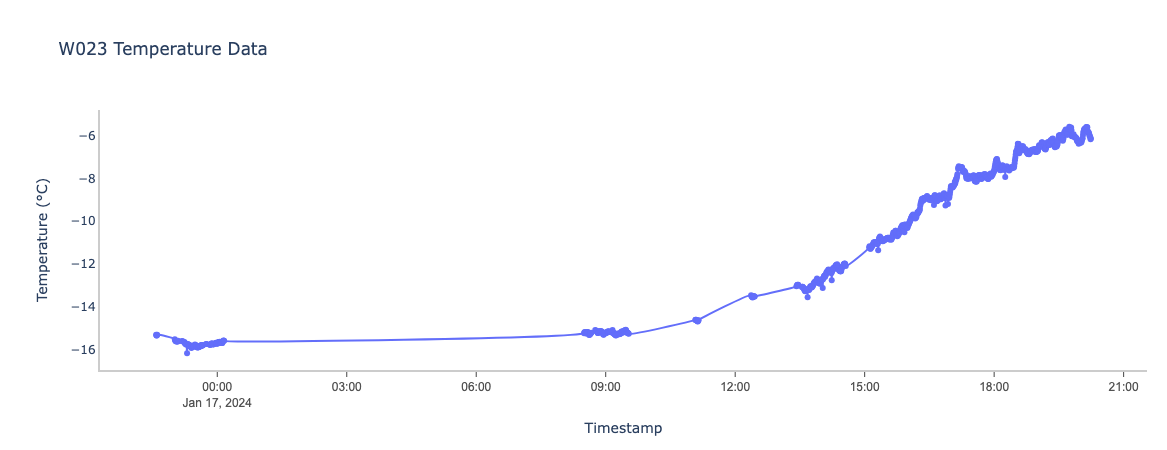

In [ ]:
try:
    for message in consumer:
        message_value = json.loads(message.value)
        timestamp = message_value['timestamp']
        temperature = message_value['value']

        # Split timestamp to separate date and nanoseconds
        datetime_part, nanoseconds_part = timestamp[:-1].split('.')
        # Parse the datetime string to a datetime object
        datetime_obj = datetime.strptime(datetime_part, '%Y-%m-%dT%H:%M:%S')
        # Format the datetime object as a string without milliseconds
        formatted_timestamp = datetime_obj.strftime('%Y-%m-%d %H:%M:%S')

        metadata = message_value['meta']

        # Check if the sensor is 'bme680' and append data
        if metadata['sensor'] == 'bme680':
            timestamps.append(formatted_timestamp)
            temperatures.append(temperature)

            # Update and display the plot
            update_plot()
            clear_output(wait=True)

except KeyboardInterrupt:
    # Handle manual interruption
    pass
finally:
    # Close the Kafka consumer 
    consumer.close()